# Решение вступительного задания

In [ ]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram
from scipy.optimize import curve_fit


## **Задача № 1**

Менеджер дал задачу “посмотреть, как там дела с ретеншном” и ускакал в отпуск (вот гад). Требуется попробовать как-то ответить на вопрос на основе таблички test_data_1.
Ответ нужен в виде небольшого отчёта в Jupyter (отправить можно в виде pdf/html/ipynb).
В отчёте приветствуются комментарии/вопросы вида “что ещё хотелось бы посмотреть”, “как можно уточнить постановку задачи”, всякое такое.


In [ ]:
# Загрузка данных из файла
data = pd.read_excel('test_data_1.xlsx')

# Посмотрим первые строки таблицы
data.head()

,client_id,order_date,order_price,city_id
0,43000,2022-01-08 00:00:00,9250,2
1,43001,2022-01-14 00:00:00,8000,3
2,43002,2022-01-03 00:00:00,4550,1
3,43003,2022-01-14 00:00:00,3550,2
4,43004,2022-01-26 00:00:00,7700,3


Мы загрузили таблицу и видим, что у нас есть колонки:

- **client_id**: идентификатор клиента
- **order_date**: дата заказа
- **order_price**: цена заказа
- **city_id**: идентификатор города

Супер, теперь перейдём к решению задачи

*Retention — это метрика, отвечающая на вопрос, сколько людей вернулись в день Х (неделю Х, месяц Х) после первого входа в продукт. Retention измеряется в процентах, то есть показывает долю вернувшихся людей от изначально пришедших.*

Для анализа ретеншна нам важно определить, сколько раз клиенты совершают повторные покупки и в какие временные периоды. Прежде чем перейти к расчетам, убедимся, что данные корректны и подготовим их к анализу.


In [ ]:
# Просмотр типа данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10926 entries, 0 to 10925
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   client_id    10926 non-null  int64 
 1   order_date   10926 non-null  object
 2   order_price  10926 non-null  int64 
 3   city_id      10926 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 341.6+ KB


Видим, что колонка order_date - имеет тип str. Переведём её в формат datetime64

In [ ]:
# Преобразуем столбец order_date в формат datetime
data['order_date'] = pd.to_datetime(data['order_date'])

# Проверка преобразований
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10926 entries, 0 to 10925
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   client_id    10926 non-null  int64         
 1   order_date   10926 non-null  datetime64[ns]
 2   order_price  10926 non-null  int64         
 3   city_id      10926 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 341.6 KB


Теперь, когда у нас есть данные в нужном формате, создадим когортный анализ. Мы будем группировать клиентов по месяцу их первого заказа и отслеживать их повторные заказы по месяцам.

Для этого:

**1.**   Определим месяц первого заказа для каждого клиента

**2.**   Создадим когортные группы по месяцу первого заказа

**3.**   Расчитаем количество клиентов, совершивших повторные заказы в последующие месяцы


In [ ]:
# Определим месяца первого заказа для каждого клиента
data['first_order_month'] = data.groupby('client_id')['order_date'].transform('min').dt.to_period('M')

# Определим месяца каждого заказа
data['order_month'] = data['order_date'].dt.to_period('M')

# Сгруппируем данные для когортного анализа
cohort_data = data.groupby(['first_order_month', 'order_month']).agg(n_customers=('client_id', 'nunique')).reset_index()

# Создадим столбец для числового значения месяца
cohort_data['cohort_period'] = (cohort_data['order_month'] - cohort_data['first_order_month']).apply(lambda x: x.n)

# Построим когортную таблицу
cohort_pivot = cohort_data.pivot_table(index='first_order_month', columns='cohort_period', values='n_customers')

# Заполним пропущенные значения
cohort_pivot.fillna(0, inplace=True)

cohort_pivot

cohort_period,0,1,2,3
first_order_month,,,,
2022-01,957.0,152.0,30.0,12.0
2022-02,883.0,150.0,26.0,3.0
2022-03,935.0,145.0,40.0,7.0
2022-04,901.0,115.0,33.0,3.0
2022-05,860.0,98.0,19.0,2.0
2022-06,831.0,107.0,20.0,3.0
2022-07,866.0,81.0,15.0,2.0
2022-08,907.0,77.0,8.0,0.0
2022-09,866.0,60.0,0.0,0.0


В таблице выше показано количество уникальных клиентов, которые совершили повторные заказы в течение месяцев после первого заказа.

Столбец **0** указывает на количество клиентов, которые совершили заказы в первый месяц.

Столбец **1** указывает на количество клиентов, которые вернулись и совершили заказы во второй месяц и так далее.

*Рассчитаем проценты удержания*

Для лучшего понимания динамики удержания клиентов рассчитаем процент удержания для каждой когорты.

In [ ]:
# Рассчитаем процент удержания
cohort_size = cohort_pivot.iloc[:, 0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0) * 100

retention_matrix

cohort_period,0,1,2,3
first_order_month,,,,
2022-01,100.0,15.882968,3.134796,1.253918
2022-02,100.0,16.987542,2.944507,0.339751
2022-03,100.0,15.508021,4.278075,0.748663
2022-04,100.0,12.763596,3.662597,0.332963
2022-05,100.0,11.395349,2.209302,0.232558
2022-06,100.0,12.876053,2.406739,0.361011
2022-07,100.0,9.353349,1.732102,0.230947
2022-08,100.0,8.489526,0.882029,0.000000
2022-09,100.0,6.928406,0.000000,0.000000


Какие дальнейшие шаги мы можем предпринять:


*   Обратить внимание, как меняется удержание по разным когортам в
зависимости от месяца первого заказа. Например, есть ли сезонные колебания?
*   Посмотреть на влияние факторов, проанализировав, как разные факторы (например, order_price, city_id) влияют на удержание клиентов
*   Детализаровать анализ, разбив анализ на более мелкие временные промежутки, такие как недели

## **Задача 2**

В test_data_2 лежат какие-то бинарные вектора. Определите, сколько в них кластеров. Попробуйте как-то описать получившееся кластеры.


In [ ]:
# Загрузка данных из файла
data = pd.read_excel('test_data_2.xlsx')

# Просмотр первых строк таблицы
data.head()

,0,1,2,3,4,5,6
0,0,1,0,1,1,1,0
1,0,1,0,0,1,0,1
2,0,1,0,0,1,0,0
3,0,0,1,0,1,1,0
4,0,0,0,1,1,0,1


In [ ]:
# Просмотр информации о имеющихся данных
data.info()

# Как мы видим - все данные заполнены

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       240 non-null    int64
 1   1       240 non-null    int64
 2   2       240 non-null    int64
 3   3       240 non-null    int64
 4   4       240 non-null    int64
 5   5       240 non-null    int64
 6   6       240 non-null    int64
dtypes: int64(7)
memory usage: 13.2 KB


Для рашения задачи кластеризации применим следующие методы


*   AgglomerativeClustering
*   DBSCAN
*   KMeans

In [ ]:
# Отключение предупреждений
import warnings
warnings.filterwarnings("ignore")

# Определим оптимальное количество кластеров методом локтя для K-means
def optimal_kmeans(data, k=10, seed=101):
    inertia = []
    K = range(1, k)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=seed).fit(data)
        inertia.append(kmeans.inertia_)
    plt.figure(figsize=(10, 7))
    plt.plot(K, inertia, 'bx-')
    plt.xlabel('Количество кластеров')
    plt.ylabel('Inertia')
    plt.title('Метод локтя для K-means')
    plt.show()

# Определим оптимальное количество кластеров для иерархической кластеризации
def optimal_hierarchical(data):
    linked = linkage(data, method='ward')
    dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
    plt.title('Дендрограмма для иерархической кластеризации')
    plt.show()

# Применение кластеризации и расчет метрик
def cluster_and_evaluate(data, n_clusters_KMeans=2, n_clusters_AggClust=2, seed=101):
    # K-means
    kmeans = KMeans(n_clusters=n_clusters_KMeans, random_state=seed).fit(data)
    kmeans_labels = kmeans.labels_
    kmeans_silhouette = silhouette_score(data, kmeans_labels)

    # Hierarchical Clustering
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters_AggClust).fit(data)
    hierarchical_labels = hierarchical.labels_
    hierarchical_silhouette = silhouette_score(data, hierarchical_labels)

    # DBSCAN
    dbscan = DBSCAN(eps=0.5, min_samples=2).fit(data)
    dbscan_labels = dbscan.labels_
    dbscan_silhouette = silhouette_score(data, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1

    return {
        "K-means Silhouette Score": kmeans_silhouette,
        "Hierarchical Silhouette Score": hierarchical_silhouette,
        "DBSCAN Silhouette Score": dbscan_silhouette
    }

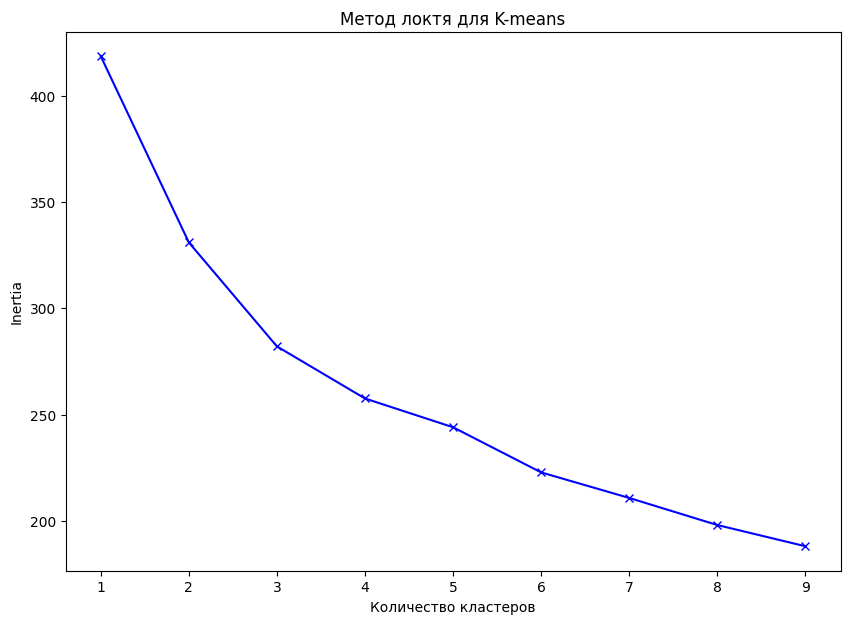

In [ ]:
# С помощью метода локтя подберём оптимальное число кластеров KMeans

optimal_kmeans(data, k=10)

# Интерция (inertia) в контексте K-means кластеризации —
# метрика, которая измеряет сумму квадратов расстояний между точками данных и их соответствующими центроидами
# Выберем оптимальным числом k = 3

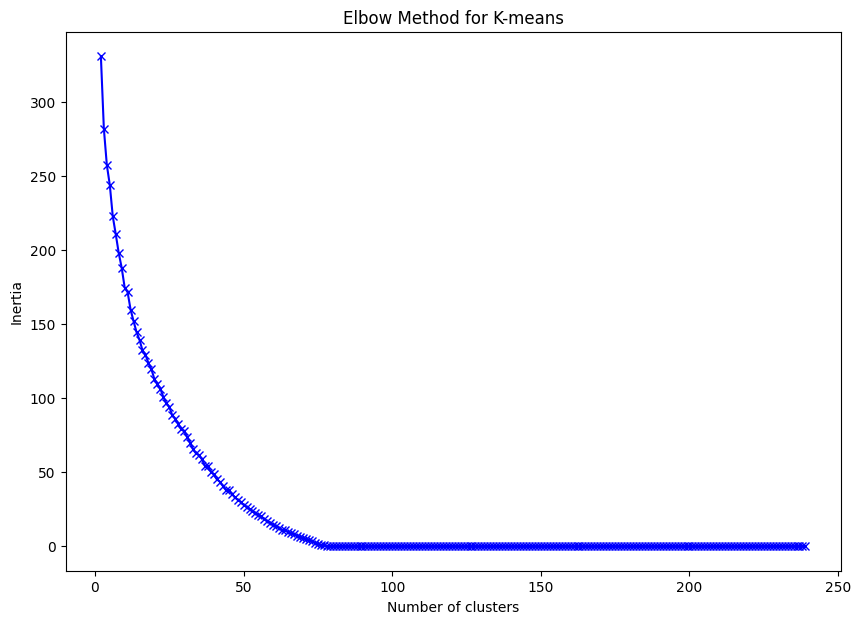

76

In [ ]:
# Доработаем код, для подсчёта оптимального значения для k
def optimal_kmeans(data, seed=101):
    inertia = []
    silhouette_scores = []
    K = range(2, len(data))
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=seed, n_init=10).fit(data)
        inertia.append(kmeans.inertia_)
        score = silhouette_score(data, kmeans.labels_)
        silhouette_scores.append(score)

    plt.figure(figsize=(10, 7))
    plt.plot(K, inertia, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for K-means')
    plt.show()

    optimal_k = K[np.argmax(silhouette_scores)]
    return optimal_k


optimal_kmeans(data, seed=101)

# Таким образом оптимальноче число кластеров будет равно 76

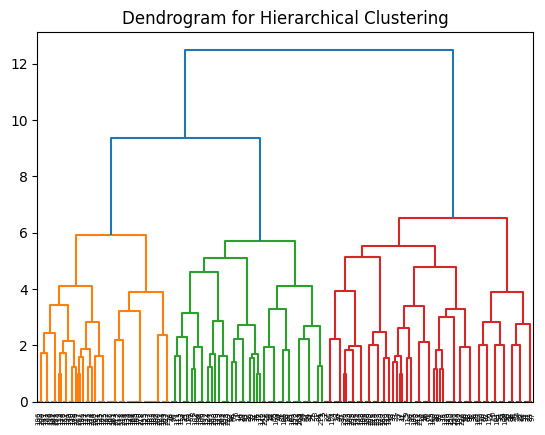

73

In [ ]:
# Аналогичным образом попробуем доработать дендограмму

def optimal_hierarchical(data):
    linked = linkage(data, method='ward')
    dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
    plt.title('Dendrogram for Hierarchical Clustering')
    plt.show()

    silhouette_scores = []
    for k in range(2, len(data)):
        hierarchical = AgglomerativeClustering(n_clusters=k).fit(data)
        score = silhouette_score(data, hierarchical.labels_)
        silhouette_scores.append(score)

    optimal_k = range(2, len(data))[np.argmax(silhouette_scores)]
    return optimal_k

optimal_hierarchical(data)

# Таким образом оптимальноче число кластеров будет равно 73

In [ ]:
cluster_and_evaluate(data, n_clusters_KMeans=76, n_clusters_AggClust=73, seed=101)

# Мы получаем достаточно большое значение метрики для методов K-means и Hierarchical

{'K-means Silhouette Score': 0.9291666666666667,
 'Hierarchical Silhouette Score': 0.9291666666666667,
 'DBSCAN Silhouette Score': 0.8969364018794409}

In [ ]:
# Посмотрим какое значение кластеров даст нам DBSCAN...
# Для этого переберём гиперпараметры метода и посмотрим на наилучший результат

def optimal_dbscan(data):
    eps_values = np.arange(0.1, 1.1, 0.1)
    min_samples_values = range(1, 5)
    best_score = -1
    best_params = None
    best_labels = None

    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(data)
            labels = dbscan.labels_
            if len(set(labels)) > 1:
                score = silhouette_score(data, labels)
                if score > best_score:
                    best_score = score
                    best_params = (eps, min_samples)
                    best_labels = labels

    return best_params, best_labels, best_score

# Применение DBSCAN и вывод оптимальных параметров и количества кластеров
best_params, best_labels, best_score = optimal_dbscan(data)
num_clusters = len(set(best_labels)) - (1 if -1 in best_labels else 0)
best_params, num_clusters, best_score


((0.1, 1), 78, 0.9291666666666667)

Таким образом с помощью перебора гиперпараметров, мы можем улучшить результат любого из перечисленных выше методов
Остановимся на полученном результате и зафиксируем, что:

число кластеров будет равно - 78

## **Задача 3**

В test_data_3 содержатся результаты некоторого измерения, имеющего вид **z = (a+x) ^ (b+y) + eps**.

***a***, ***b***  – действительные числа между 1 и 10

***eps*** – небольшой шум из Uniform(0,0.1)

***^*** – степень, не xor =)

Вычислите a и b.


In [ ]:
# Загрузка данных из файла
data = pd.read_excel('test_data_3.xlsx')

# Просмотр первых строк таблицы
data.head()

,x,y,z
0,0.906997,0.508163,90.796488
1,0.414474,0.146153,37.823019
2,0.257263,0.964007,90.243367
3,0.301285,0.628279,62.538480
4,0.520236,0.994226,123.466112


Для того чтобы вычислить a и b из данных, нам нужно использовать метод нелинейной регрессии.

В этой задаче мы будем подбирать параметры a и b так, чтобы минимизировать разницу между измеренными значениями z и теоретическими значениями z, вычисленными по формуле **z = (a+x) ^ (b+y) + eps**


In [ ]:
# Функция для подбора параметров
def model_func(vars, a, b):
    x, y = vars
    return (a + x) ** (b + y)

# Подготовка данных
x_data = data[['x', 'y']].values.T
z_data = data['z'].values

# Подбор параметров
initial_guess = [1, 1]  # начальные приближения для a и b
params, covariance = curve_fit(model_func, x_data, z_data, p0=initial_guess)

a, b = params
print("a =", a)
print("b =", b)

a = 3.1417262098357814
b = 2.716345719787626


## **Задача 4**


На голубом вертолёте прилетел волшебник и подарил миллион рублей (после уплаты налогов) на счёте в Сбербанке. Забрать их со счёта можно через год. До того можете пользоваться депозитами, накопительными счетами, инвестиционными инструментами. Что будете делать?


**Ответ**

Первым шагом, я бы проанализировал текущие финансовые условия предлагаемые банком:

*   Проверил текущие ставки по депозитам и накопительным счетам в Сбербанке
*   Узнал бы о текущих инвестиционных предложениях, таких ПИФы, биржевые фонды (ETF) и другие инвестиционные инструменты, доступные через Сбербанк

Затем, можно было бы составить сратегию

***Консервативный подход:***

**Депозиты и накопительные счета:** Рассмотреть возможность размещения части средств на срочных депозитах с максимальной процентной ставкой, предлагаемых Сбербанком. Обычно срочные депозиты имеют более высокую ставку, чем накопительные счета, но средства будут заморожены на срок действия депозита. Что нас устраивает.

***Умеренный подход:***

**ПИФы и ETF:** Рассмотреть возможность вложения части средств в паевые инвестиционные фонды или ETF через Сбербанк. Эти инструменты предлагают возможность получения более высокой доходности за счет инвестиций в акции, облигации и другие активы, но также несут определенный риск.

***Агрессивный подход:***

**Инвестиции в акции:** Акции могут приносить высокую доходность, но также могут сильно колебаться в цене. Что на мой взгляд не особо мне подходит.

Поэтому, выберу умеренный подход:

**Пример распределения для умеренного подхода:**

40% на срочные депозиты с высокой процентной ставкой

30% на накопительный счет для обеспечения ликвидности

30% в ПИФы и ETF для получения потенциально более высокой доходности при разумном уровне риска

## **Задача 5**

Известно, что немало работающих на человеческих факторах моделей (скоринг, ранжирование, рекомендашки) сочтут довольно полезными такие данные как национальность, цвет кожи, рост, вес, IQ. Но как-то будут и без них работать. Пусть вы как раз тюните модель, для которой такое поведение характерно, и соцдем-данные в принципе можно достать. Ваши действия?


**Ответ**

При получении новых данных, я сначала проверю их на корректность и заполненность. Проведу анализ количества отсутствующих значений, проверку данных на наличие ошибок, дубликатов и аномалий.

Затем проведу корреляционный анализ и оценю важность новых признаков, чтобы понять, какие из них могут наиболее сильно повлиять на целевую переменную и улучшить предсказания модели. Возможно, я создам новые признаки на основе полученных данных и проведу оптимизацию гиперпараметров модели, чтобы учесть новые данные и максимально улучшить производительность.

После интеграции новых данных я создам две модели: одну с использованием новых данных и одну без. Сравню их по ключевым метрикам на кросс-валидации и тестовой выборке, чтобы оценить, насколько новые данные влияют на точность, полноту и другие важные показатели модели. Затем буду принимать дальнейшее решение о использовании новых даных.